In [1]:
import gstools as gs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
import xarray as xr
import cartopy.crs as ccrs
from cartopy import geodesic as cgeod
from geopy.distance import geodesic 
import cartopy.feature as cfeature
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap, Normalize

import matplotlib.cm as cm
from multiprocess import Pool

import matplotlib.colors as mcolors
import cmcrameri.cm as cmc
import os
import scipy.stats as stats


In [2]:
# Define seasons based on month
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return "DJF"
    elif month in [3, 4, 5]:
        return "MAM"
    elif month in [6, 7, 8]:
        return "JJA"
    elif month in [9, 10, 11]:
        return "SON"

In [3]:
stn_id = 40082
df_scale = pd.read_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_qc/{stn_id}_pair_scale_moving_list_all_events.csv",index_col=0)
df = df_scale[df_scale["scale"]>5].reset_index()

In [4]:
df["Date"] = pd.to_datetime(df["extreme_dates"])
df["Season"] = df["Date"].apply(get_season)

In [5]:
df_1980 = df[df['Date'].dt.year < 1980]

# Calculate 66th percentile by season
seasonal_66th_percentile = df_1980.groupby('Season')['scale'].quantile(0.50)

In [6]:
seasonal_66th_percentile

Season
DJF    334.162973
JJA    493.629499
MAM    295.761419
SON    218.792901
Name: scale, dtype: float64

In [7]:
df["Year"] = df['Date'].dt.year

In [8]:
df_pc = df.merge(seasonal_66th_percentile, on='Season')

In [9]:

# Count the number of events exceeding the seasonal 66th percentile per Year and Season
df_counts = (
    df_pc[df_pc['scale_x'] > df_pc['scale_y']]
    .groupby(['Year', 'Season'])
    .size()
    .reset_index(name='exceedance_count')
)

In [10]:
df_tot = (
    df_pc
    .groupby(['Year', 'Season'])
    .size()
    .reset_index(name='tot_count')
)

In [24]:
comparison_df = df_tot.merge(df_counts, on=['Year', 'Season'], how='left').fillna(0)

# Calculate the exceedance ratio
comparison_df['exceedance_ratio'] = comparison_df['exceedance_count'] / comparison_df['tot_count']


In [25]:
comparison_df

,Year,Season,tot_count,exceedance_count,exceedance_ratio
0,1941,DJF,2,1.0,0.50
1,1941,MAM,1,0.0,0.00
2,1942,DJF,4,3.0,0.75
3,1942,SON,2,2.0,1.00
4,1943,DJF,3,0.0,0.00
...,...,...,...,...,...
202,2023,DJF,1,0.0,0.00
203,2023,MAM,1,1.0,1.00
204,2023,SON,1,0.0,0.00
205,2024,DJF,2,0.0,0.00


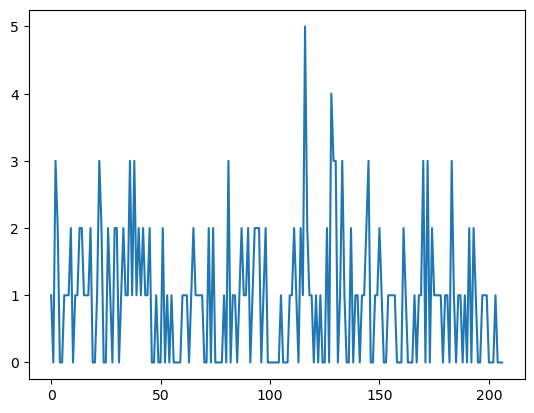

In [27]:
plt.plot(comparison_df['exceedance_count'])

In [20]:
ds_oni = xr.open_dataset("/g/data/k10/dl6968/Rain_gauge_scale/python/ENSO_oni.nc")

In [21]:
ds_oni_year = ds_oni.rolling(time=3, center=True).mean().resample(time='YS').mean()

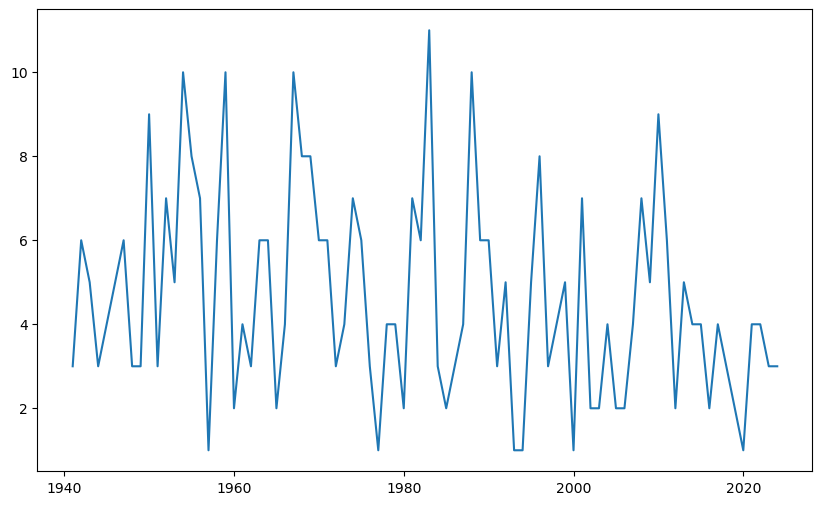

In [23]:
fig, ax_counts = plt.subplots(figsize=(10, 6))
ax_counts.plot(comparison_df['exceedance_ratio'], comparison_df['exceedance_ratio'])

# ax_enso = ax_counts.twinx()
# ax_enso.plot(np.arange(1950,2025), ds_oni_year.value, color="r")